##### __Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count

import matplotlib.patches as mpatches  # create custom plot legends
import matplotlib.pyplot as plt  # mother of plots focr Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display  # print nicely
from matplotlib.lines import Line2D  # matplotlib custom lines
from scipy import stats  # statistical tests
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

##### __Options and constants__

In [2]:
warnings.filterwarnings("ignore")

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

# specify decimals format on pandas tables
pd.options.display.float_format = "{:.2f}".format

CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 16


##### __Helper functions__

In [3]:
def pbar_fork_hack():
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    print(" ", end="", flush=True)


def bartlett_test(df):
    # check if the variance is homogeneous
    # collect conditions
    conds = df.condition.unique()

    print("Sky % variance per condition:")
    cond_var = pd.DataFrame(columns=conds)
    for cond in conds:
        cond_var[cond] = df[df.condition == cond].var()
    display(cond_var)

    # check for variance homogeneity using Bartlett's test:
    bartlett_pv = stats.bartlett(
        df[df.condition == "AVAS"]["sky_%"],
        df[df.condition == "TaxiDriver"]["sky_%"],
        df[df.condition == "RadioTalk"]["sky_%"],
    )[1]

    print(f"Bartlett's p-value is {bartlett_pv:.12f}")
    print("So, is the variance (Sky %) between groups homogeneous (p > 0.05)?")
    res = bartlett_pv > 0.05
    print(res)
    return res


def t_test(df, eq_var):
    # conditions
    conds = df.condition.unique()
    # combinations of conditions to test
    combs = list(itertools.combinations(conds, 2))
    # tranlate combinations (tuples) to column names
    combs_str = [f"{c[0]} vs {c[1]}" for c in combs]
    # df result to fill out
    res = pd.DataFrame(columns=combs_str)

    # iterate over combinations to compute t-test
    for i, c in enumerate(combs_str):
        # select groups to test
        first_grp = df[df.condition == combs[i][0]]["sky_%"]
        second_grp = df[df.condition == combs[i][1]]["sky_%"]
        # p-value using Student's (equal var) or Welch's t-test (diff var)
        values = stats.ttest_ind(first_grp, second_grp, equal_var=eq_var)
        res.loc["p-value", c] = values[1]
        check = "✔️" if values[1] < 0.05 else "❌"
        res.loc["significance", c] = check

    display(res)

In [4]:
# store and preview the enhanced participants list
parts_sky = pd.read_csv("./participants_sky.csv", index_col=0)
parts_sky

,date,expo,side,condition,questionnaire,sky_%
id,,,,,,
4f583872ffed48249874b00f3d389cfc,2019-05-14 13:21:00,MSW,right,TaxiDriver,No,13.74
33d68ad55ef544fab9fd08108e3913ca,2019-05-14 16:44:00,MSW,right,AVAS,No,0.67
8598a83e2af441b8bcd0ae5d84beb875,2019-05-14 16:51:00,MSW,right,RadioTalk,No,33.13
37d7e67934974217830bb429bba7fd76,2019-05-14 16:54:00,MSW,left,AVAS,No,18.61
42bac596059749b5b8e8e83ae61de9b4,2019-05-14 16:56:00,MSW,right,TaxiDriver,No,26.99
...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,2019-12-30 15:29:00,BMBF,right,AVAS,No,32.16
611d35a7c3e940cc82495e53c2a8532d,2020-01-03 16:12:00,BMBF,right,TaxiDriver,No,15.46
3b6fda285d9e412eb081986b2f22a2e3,2020-01-03 16:13:00,BMBF,left,AVAS,No,3.37


Gaussian fit of Sky % distribution

mean: 13.4343411860473
std: 12.293261557821856


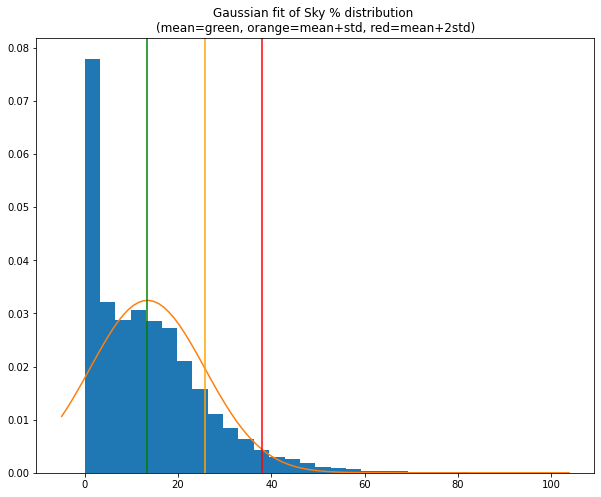

In [5]:
mean, std = stats.norm.fit(parts_sky["sky_%"])
print(f"mean: {mean}")
print(f"std: {std}")

plt.rcParams["figure.figsize"] = (10, 8)
plt.hist(parts_sky["sky_%"], bins=30, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = stats.norm.pdf(x, mean, std)
plt.plot(x, y)
plt.axvline(mean, color="g")
plt.axvline(mean + std, color="orange")
plt.axvline(mean + std * 2, color="r")

plt.title(
    "Gaussian fit of Sky % distribution \n(mean=green, orange=mean+std, red=mean+2std)"
)
plt.show()

How many participants are outliers (more than 2 std)?

In [6]:
total_parts = parts_sky.index.size
total_out = parts_sky[parts_sky["sky_%"] > mean + std * 2].index.size
perc_out = total_out * 100 / total_parts

soft_out = parts_sky[parts_sky["sky_%"] > mean + std].index.size
perc_soft = soft_out * 100 / total_parts

print(
    f"From a total of {total_parts} (100%) participants (mean={mean:.2f}, std={std:.2f}):"
)
print(
    f"=> {total_out} ({perc_out:.2f}%) are clear outliers (> mean + 2 * std)"
)
print(f"=> {soft_out} ({perc_soft:.2f}%) are soft outliers (> mean + std)")

From a total of 24356 (100%) participants (mean=13.43, std=12.29):
=> 1061 (4.36%) are clear outliers (> mean + 2 * std)
=> 3508 (14.40%) are soft outliers (> mean + std)


How are the conditions distributed before and after removing the outliers?

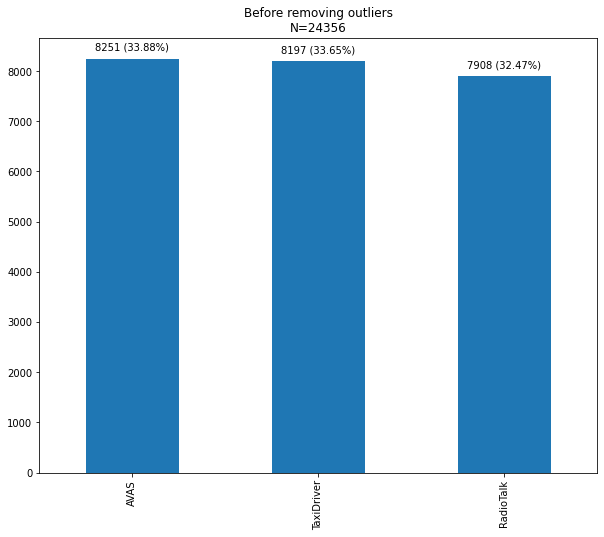

Sky % variance per condition:


,TaxiDriver,AVAS,RadioTalk
sky_%,163.75,144.40,143.56


Bartlett's p-value is 0.000000000122
So, is the variance (Sky %) between groups homogeneous (p > 0.05)?
False

Is the difference between % of sky between conditions significant?


,TaxiDriver vs AVAS,TaxiDriver vs RadioTalk,AVAS vs RadioTalk
p-value,0.00000000000050669262,0.00000000000000049229,0.32351035160949759284
significance,✔️,✔️,❌


In [7]:
sel = parts_sky
N = sel.index.size
title = f"Before removing outliers\nN={parts_sky.index.size}"
ax = sel["condition"].value_counts().plot(kind="bar", title=title)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()
    perc = height * 100 / N
    ax.annotate(
        f"{height} ({perc:.2f}%)",
        (x + width / 2, y + height * 1.02),
        ha="center",
    )
plt.show()

eq_var = bartlett_test(sel)

# specify decimals format on pandas tables
pd.options.display.float_format = "{:.20f}".format
print()
print("Is the difference between % of sky between conditions significant?")
t_test(sel, eq_var)

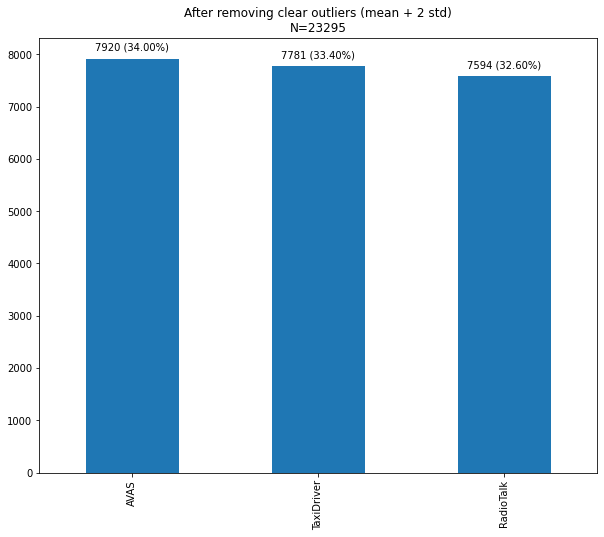

Sky % variance per condition:


,TaxiDriver,AVAS,RadioTalk
sky_%,103.74124717831385567024,93.60369381614789574542,93.48546182025461348530


Bartlett's p-value is 0.000000817330
So, is the variance (Sky %) between groups homogeneous (p > 0.05)?
False

Is the difference between % of sky between conditions significant?


,TaxiDriver vs AVAS,TaxiDriver vs RadioTalk,AVAS vs RadioTalk
p-value,0.00000000002410925112,0.00000000000001488566,0.26695310791332238498
significance,✔️,✔️,❌


In [8]:
sel = parts_sky[parts_sky["sky_%"] < mean + std * 2]
N = sel.index.size
title = f"After removing clear outliers (mean + 2 std)\nN={sel.index.size}"
ax = sel["condition"].value_counts().plot(kind="bar", title=title)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()
    perc = height * 100 / N
    ax.annotate(
        f"{height} ({perc:.2f}%)",
        (x + width / 2, y + height * 1.02),
        ha="center",
    )
plt.show()

eq_var = bartlett_test(sel)

# specify decimals format on pandas tables
pd.options.display.float_format = "{:.20f}".format
print()
print("Is the difference between % of sky between conditions significant?")
t_test(sel, eq_var)

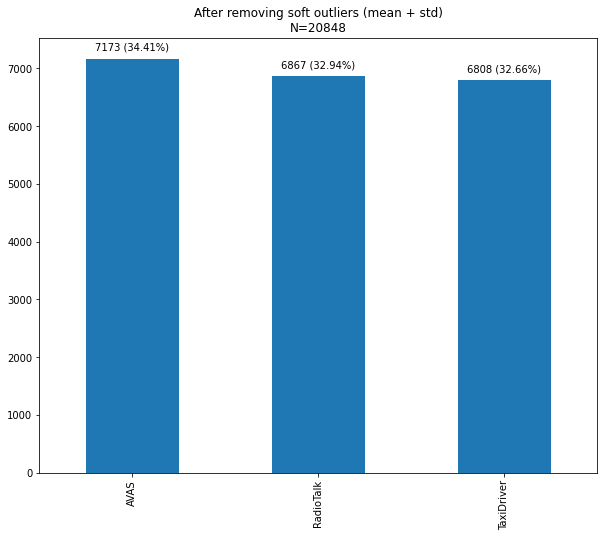

Sky % variance per condition:


,TaxiDriver,AVAS,RadioTalk
sky_%,61.54657189513888937427,60.54552913716717910120,57.81004219808566091388


Bartlett's p-value is 0.027284192976
So, is the variance (Sky %) between groups homogeneous (p > 0.05)?
False

Is the difference between % of sky between conditions significant?


,TaxiDriver vs AVAS,TaxiDriver vs RadioTalk,AVAS vs RadioTalk
p-value,0.00192217403502397614,0.00000057605067689929,0.05358639982625566095
significance,✔️,✔️,❌


In [9]:
sel = parts_sky[parts_sky["sky_%"] < mean + std]
N = sel.index.size
title = f"After removing soft outliers (mean + std)\nN={N}"
ax = sel["condition"].value_counts().plot(kind="bar", title=title)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()
    perc = height * 100 / N
    ax.annotate(
        f"{height} ({perc:.2f}%)",
        (x + width / 2, y + height * 1.02),
        ha="center",
    )
plt.show()

eq_var = bartlett_test(sel)

# specify decimals format on pandas tables
pd.options.display.float_format = "{:.20f}".format
print()
print("Is the difference between % of sky between conditions significant?")
t_test(sel, eq_var)

Store outliers

In [15]:
parts_out = pd.DataFrame(parts_sky.condition)
parts_out["2std"] = parts_sky["sky_%"] > mean + std * 2
parts_out["1std"] = parts_sky["sky_%"] > mean + std

parts_out.to_csv("./outliers.csv")

parts_out

,condition,2std,1std
id,,,
4f583872ffed48249874b00f3d389cfc,TaxiDriver,False,False
33d68ad55ef544fab9fd08108e3913ca,AVAS,False,False
8598a83e2af441b8bcd0ae5d84beb875,RadioTalk,False,True
37d7e67934974217830bb429bba7fd76,AVAS,False,False
42bac596059749b5b8e8e83ae61de9b4,TaxiDriver,False,True
...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,AVAS,False,True
611d35a7c3e940cc82495e53c2a8532d,TaxiDriver,False,False
3b6fda285d9e412eb081986b2f22a2e3,AVAS,False,False
